In [210]:
import slideflow as sf
import polars as pl
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
import torch

In [3]:
from scipy.stats import scoreatpercentile

## https://stackoverflow.com/questions/3878245/tukey-five-number-summary-in-python

def fivenumquantile(v):
    """Returns Tukey's five number summary (minimum, lower-hinge, median, upper-hinge, maximum) for the input vector, a list or array of numbers based on 1.5 times the interquartile distance"""
    try:
        np.sum(v)
    except TypeError:
        print('Error: you must provide a list or array of only numbers')
    q1 = scoreatpercentile(v[~np.isnan(v)],25)
    q3 = scoreatpercentile(v[~np.isnan(v)],75)
    md = np.median(v[~np.isnan(v)])
    return np.nanmin(v), q1, md, q3, np.nanmax(v),

# Colorectal Slides - Colour Channel Deconvolution

In this notebook, I investigate whether it is possible to detect tiles which are outliers due to being drawn on top, by looking at the pixel colour statistics in the image. The main idea is to define two colour vectors which correspond to H and E staining, and then see:

1) whether a 3rd, orthogonal channel will be large for images which are drawn on
2) whether in general, tiles with artefacts will be "outliers" when looking at the colour intensities, and we can classify them in an unsupervised manner. 

First, we load in the slideflow project:

In [4]:
P = sf.Project(
  '/home/smirnov/colorectalMSI',
)

In [5]:
# P.add_source(
#   name="COAD_READ",
#   slides="/home/smirnov/g/huber/users/smirnov/tcga_colo_dataset/slides",
#   roi="/home/smirnov/g/huber/users/smirnov/tcga_colo_dataset/roi",
#   tiles="/home/smirnov/g/huber/users/smirnov/tcga_colo_dataset/tiles",
#   tfrecords="/home/smirnov/g/huber/users/smirnov/tcga_colo_dataset/tfrecords"
# )

In [8]:
sf.slide_backend()

'cucim'

In [9]:
sf.backend()

'torch'

In [10]:
test_slide_blue_mark = "TCGA-DM-A28M-01Z-00-DX1.055b2d62-8a1e-4bdf-a49e-123ad0de657b"

In [16]:
sf.io.detect_tfrecord_format("/scratch/smirnov/colo_tfrecords/512px_256um/TCGA-DM-A28M-01Z-00-DX1.055b2d62-8a1e-4bdf-a49e-123ad0de657b.tfrecords")

(['image_raw', 'slide', 'loc_x', 'loc_y'], 'png')

In [65]:
x,tile = sf.io.get_tfrecord_by_index("/scratch/smirnov/colo_tfrecords/512px_256um/TCGA-DM-A28M-01Z-00-DX1.055b2d62-8a1e-4bdf-a49e-123ad0de657b.tfrecords", 10)

ValueError: not enough values to unpack (expected 3, got 2)

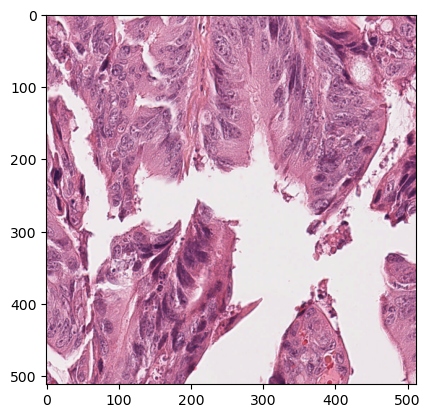

In [22]:
plt.imshow(tile)

The first method that I will try is the method from Macenko et al. using PCA to determine the first two principle directions to estimate the stain vectors. The method is pretty simple, it log transforms the measured values to linearize, then finds singular vectors 

In [23]:
squashed_tile = tile.reshape([-1,3])

In [24]:
squashed_tile

tensor([[208, 136, 178],
        [203, 145, 189],
        [216, 158, 191],
        ...,
        [224, 191, 208],
        [233, 198, 219],
        [245, 215, 223]], dtype=torch.uint8)

In [25]:
tile

tensor([[[208, 136, 178],
         [203, 145, 189],
         [216, 158, 191],
         ...,
         [192, 118, 146],
         [162, 110, 165],
         [148, 116, 173]],

        [[223, 146, 182],
         [206, 141, 188],
         [214, 145, 186],
         ...,
         [165,  91, 125],
         [216, 132, 158],
         [211, 137, 171]],

        [[241, 141, 161],
         [223, 149, 177],
         [216, 147, 179],
         ...,
         [122,  73, 140],
         [171,  87, 117],
         [185, 111, 140]],

        ...,

        [[163,  89, 127],
         [217, 135, 183],
         [252, 188, 216],
         ...,
         [223, 196, 206],
         [241, 216, 219],
         [237, 213, 224]],

        [[174,  97, 132],
         [210,  97, 146],
         [208, 101, 134],
         ...,
         [218, 188, 202],
         [238, 209, 219],
         [241, 219, 230]],

        [[136,  51,  75],
         [169,  71,  92],
         [193,  79,  98],
         ...,
         [224, 191, 208],
        

In [26]:
pca = sk.decomposition.PCA()

In [27]:
pca.fit(squashed_tile)

PCA()

In [28]:
X = pca.transform(squashed_tile)

In [29]:
X

array([[  3.91756428,  14.56395674,   7.43612177],
       [ -6.04536455,   4.15057462,  11.82947152],
       [-22.31637186,   9.75485928,   5.05848086],
       ...,
       [-58.49571042,  -0.49805442,  -0.22670803],
       [-73.47033172,   2.31279812,   4.11608196],
       [-93.18945452,   4.94470429,  -3.179757  ]])

In [30]:
squashed_tile.numpy()/255.0

array([[0.81568627, 0.53333333, 0.69803922],
       [0.79607843, 0.56862745, 0.74117647],
       [0.84705882, 0.61960784, 0.74901961],
       ...,
       [0.87843137, 0.74901961, 0.81568627],
       [0.91372549, 0.77647059, 0.85882353],
       [0.96078431, 0.84313725, 0.8745098 ]])

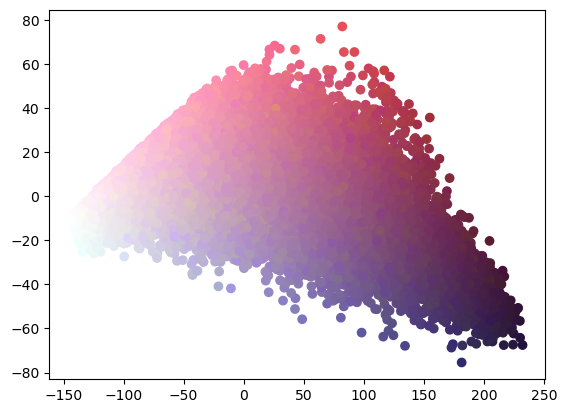

In [31]:
plt.scatter(X[:,0], X[:,1], c=squashed_tile.numpy()/255.0)
plt.show()

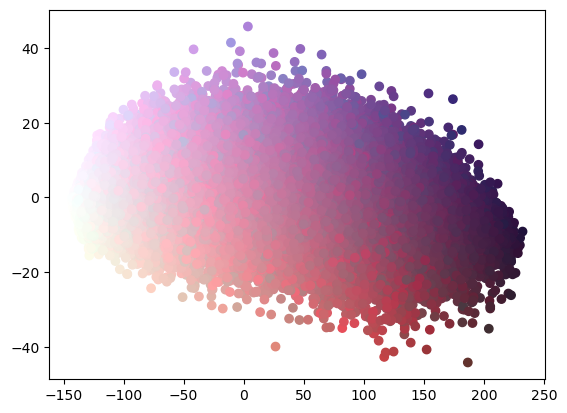

In [32]:
plt.scatter(X[:,0], X[:,2], c=squashed_tile.numpy()/255.0)
plt.show()

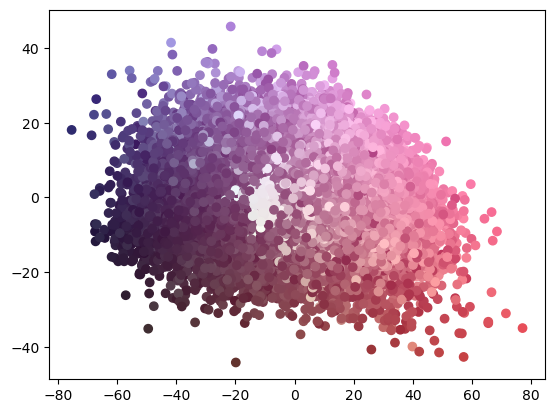

In [33]:
plt.scatter(X[:,1], X[:,2], c=squashed_tile.numpy()/255.0)
plt.show()

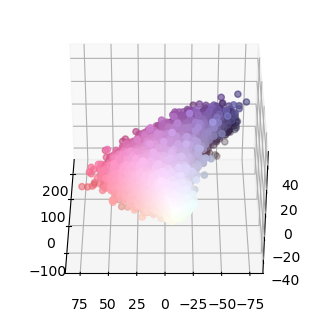

In [34]:
fig = plt.figure(1, figsize=(4, 3))
ax = fig.add_subplot(111, projection="3d", elev=35, azim=180)
ax.set_position([0, 0, 0.85, 1])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=squashed_tile.numpy()/255.0)
plt.show()

In [35]:
OD_tile = -np.log10(squashed_tile/255.0)
fivenumquantile(OD_tile[:,0]),fivenumquantile(OD_tile[:,1]),fivenumquantile(OD_tile[:,2])

Error: you must provide a list or array of only numbers


/tmp/ipykernel_76/2293363394.py:11: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/IndexingUtils.h:27.)
  q1 = scoreatpercentile(v[~np.isnan(v)],25)
/tmp/ipykernel_76/2293363394.py:12: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/IndexingUtils.h:27.)
  q3 = scoreatpercentile(v[~np.isnan(v)],75)
/tmp/ipykernel_76/2293363394.py:13: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/IndexingUtils.h:27.)
  md = np.median(v[~np.isnan(v)])


Error: you must provide a list or array of only numbers
Error: you must provide a list or array of only numbers


((-0.0, 0.033628176897764206, 0.094786316, 0.1760912388563156, 0.9013902),
 (-0.0, 0.04860533028841019, 0.2762064, 0.4022188186645508, 1.2024202),
 (-0.0, 0.03918425738811493, 0.17609124, 0.2542518377304077, 0.75332767))

From the above statistics, it seems like thresholding at 0.15 might be a bit too strong, but I will try it first anyways. 

In [36]:
(OD_tile.sum(axis=1)<0.15).double().sum()

tensor(72136., dtype=torch.float64)

In [37]:
OD_tile_thresholded = OD_tile[OD_tile.sum(axis=1)>=0.15,:]
OD_tile_thresholded.shape, OD_tile.shape

(torch.Size([190008, 3]), torch.Size([262144, 3]))

In [38]:
X_log = pca.fit_transform(OD_tile_thresholded)

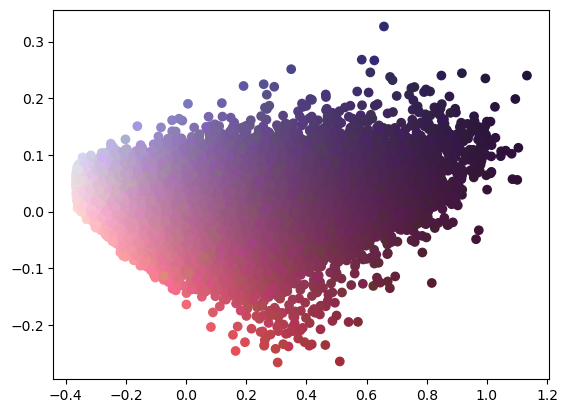

In [39]:
plot_colors = squashed_tile[OD_tile.sum(axis=1)>=0.15,:].numpy()/255.0
plt.scatter(X_log[:,0], X_log[:,1], c=plot_colors)
plt.show()

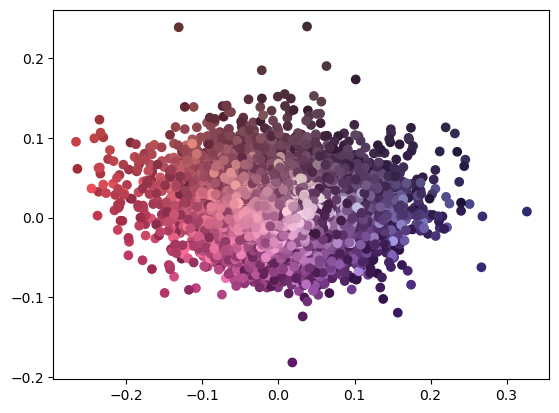

In [40]:
plt.scatter(X_log[:,1], X_log[:,2], c=plot_colors)
plt.show()

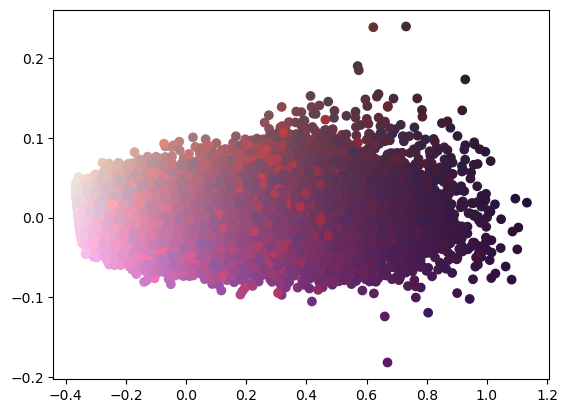

In [41]:
plt.scatter(X_log[:,0], X_log[:,2], c=plot_colors)
plt.show()

In [42]:
pca.components_, pca.explained_variance_

(array([[ 0.47585294,  0.75101008,  0.45776397],
        [ 0.82904606, -0.20921527, -0.51856687],
        [ 0.29367774, -0.62626898,  0.72217764]]),
 array([0.04408266, 0.00115327, 0.00041037]))

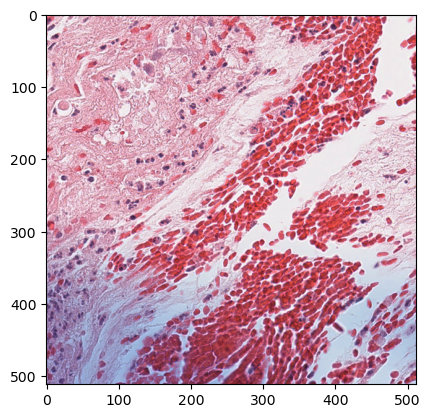

In [47]:
x,tile2 = sf.io.get_tfrecord_by_index("/scratch/smirnov/colo_tfrecords/512px_256um/TCGA-DM-A28M-01Z-00-DX1.055b2d62-8a1e-4bdf-a49e-123ad0de657b.tfrecords", 2)
plt.imshow(tile2)

In [48]:
squashed_tile2 = tile2.reshape([-1,3])
OD_tile2 = -np.log10(squashed_tile2/255.0)
OD_tile2_thresholded = OD_tile2[OD_tile2.sum(axis=1)>=0.15,:]

X2 = pca.fit_transform(OD_tile2_thresholded)

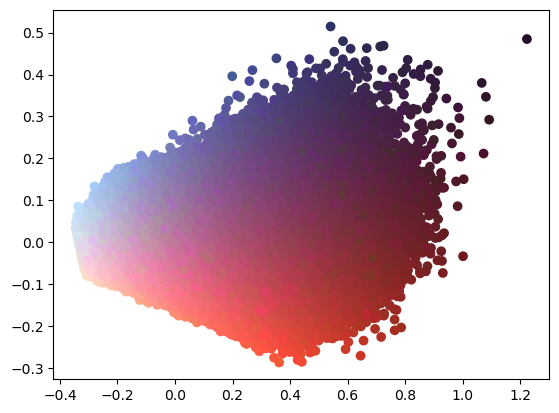

In [49]:
col_2 = squashed_tile2[OD_tile2.sum(axis=1)>=0.15].numpy()/255.0
plt.scatter(X2[:,0], X2[:,1], c=col_2)
plt.show()

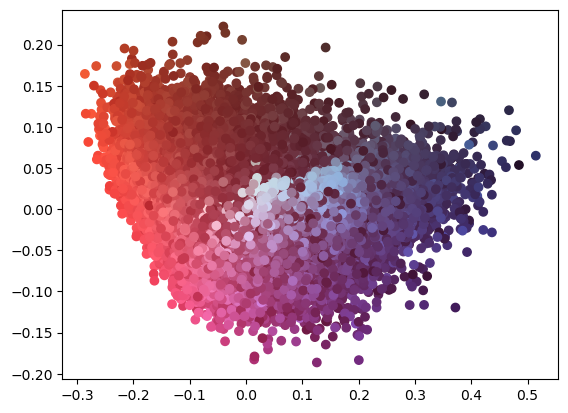

In [50]:
plt.scatter(X2[:,1], X2[:,2], c=col_2)
plt.show()

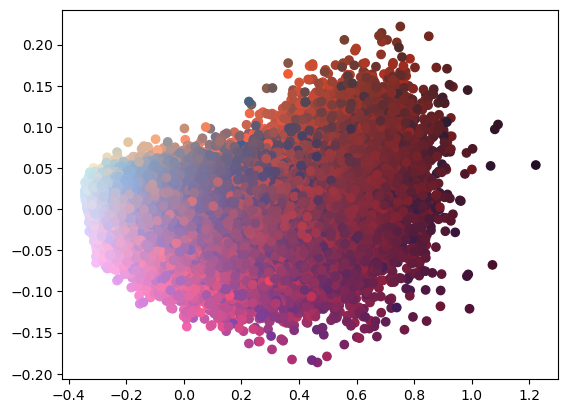

In [51]:
plt.scatter(X2[:,0], X2[:,2], c=col_2)
plt.show()

In [52]:
pca.components_, pca.explained_variance_

(array([[ 0.2379513 ,  0.74605619,  0.62191587],
        [ 0.89450647,  0.0811735 , -0.43962374],
        [ 0.3784671 , -0.66091681,  0.64803675]]),
 array([0.07357032, 0.00621027, 0.00090034]))

In [113]:
def readAndReturnTiles(path):
    dataset = sf.tfrecord.torch.dataset.TFRecordDataset(path)
    parser = sf.io.get_tfrecord_parser(
        path,
        ['image_raw'],
        decode_images=True,
        to_numpy=True,
    )
    return [parser(record) for i, record in enumerate(dataset)]


In [94]:
tfRecordPath = "/scratch/smirnov/colo_tfrecords/512px_256um/TCGA-DM-A28M-01Z-00-DX1.055b2d62-8a1e-4bdf-a49e-123ad0de657b.tfrecords"

[16:20:28] INFO     No ROI for TCGA-DM-A28M-01Z-00-DX1.055b2d62-8a1e-4bdf-a49e-123ad0de657b, using whole slide.

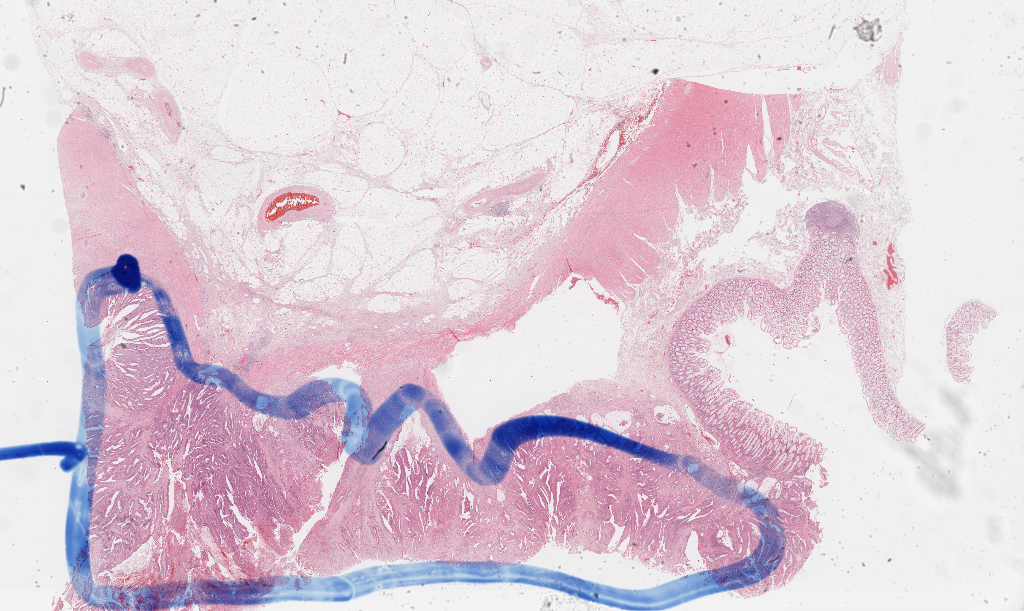

In [279]:
wsi = sf.WSI("/scratch/smirnov/colo_slides/TCGA-DM-A28M-01Z-00-DX1.055b2d62-8a1e-4bdf-a49e-123ad0de657b.svs", 512, 256)
wsi.thumb()

In [114]:
tfRDataset = readAndReturnTiles(tfRecordPath)

In [118]:
tfRDataset = [x[0] for x in tfRDataset]

In [261]:
tfRDataset[0]

tensor([[[199, 189, 197],
         [166, 142, 159],
         [173, 145, 170],
         ...,
         [224, 203, 207],
         [231, 205, 214],
         [240, 224, 236]],

        [[198, 162, 190],
         [195, 170, 204],
         [229, 215, 237],
         ...,
         [243, 249, 242],
         [230, 195, 215],
         [240, 227, 239]],

        [[236, 222, 234],
         [240, 241, 243],
         [253, 247, 254],
         ...,
         [241, 234, 231],
         [201, 176, 199],
         [212, 197, 211]],

        ...,

        [[202, 143, 157],
         [241, 221, 207],
         [248, 249, 241],
         ...,
         [240, 235, 244],
         [233, 224, 235],
         [230, 197, 216]],

        [[154, 107, 123],
         [200, 140, 147],
         [247, 212, 199],
         ...,
         [227, 193, 215],
         [218, 182, 203],
         [214, 176, 198]],

        [[145, 106, 125],
         [163, 118, 133],
         [190, 128, 130],
         ...,
         [226, 186, 209],
        

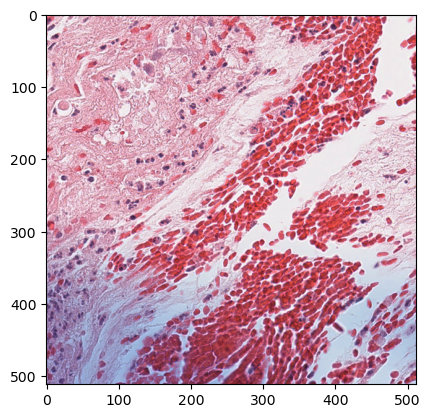

In [196]:
plt.imshow(tfRDataset[2])

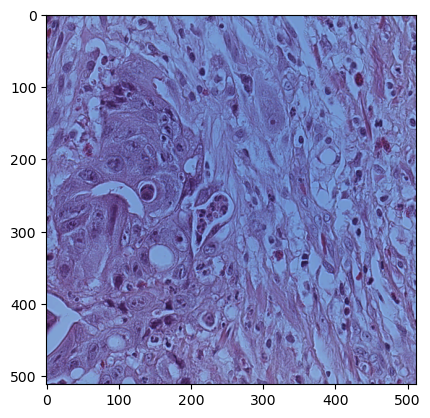

In [195]:
plt.imshow(tfRDataset[9])

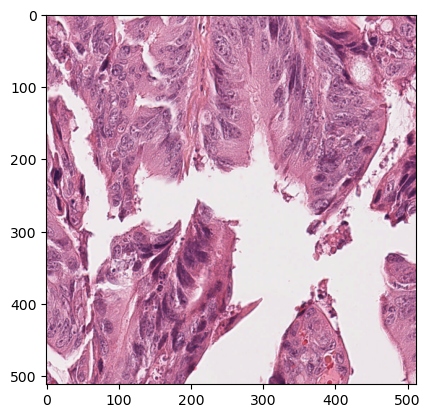

In [191]:
plt.imshow(tfRDataset[10])

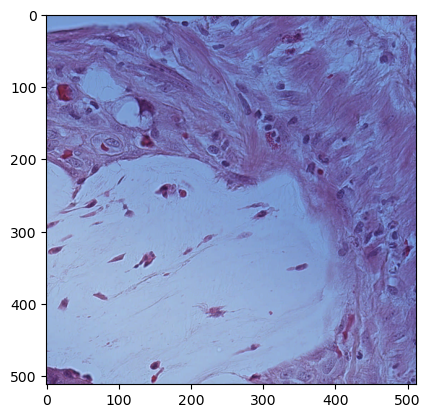

In [200]:
plt.imshow(tfRDataset[12])

Once simple idea, it looks like the means of the pixel intensities for corrupted tiles might be shifted. Lets try that out

In [237]:
tileMeans = np.stack([x.reshape(-1,3).mean(axis=0, dtype=torch.float32) for x in tfRDataset])

In [241]:
pca =  sk.decomposition.PCA()
X = pca.fit_transform(tileMeans)
X

array([[-49.937233  , -19.804089  ,   0.62414414],
       [-28.228237  ,   2.255461  ,  -1.6646106 ],
       [ 26.111805  ,  19.196127  ,   5.3454247 ],
       ...,
       [-34.810555  , -12.023891  ,   0.78826827],
       [  6.466007  , -51.272343  ,  -2.1133459 ],
       [-11.534495  ,   4.0603256 ,  -0.2736304 ]], dtype=float32)

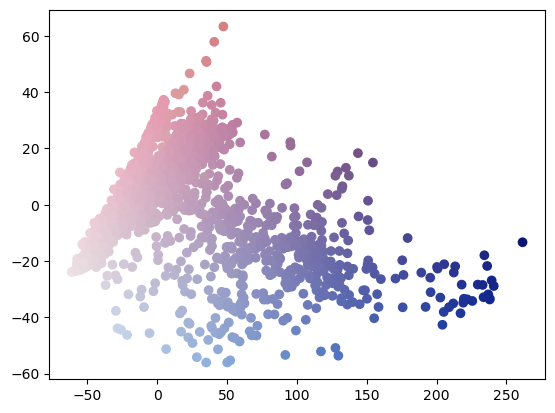

In [245]:
plt.scatter(X[:,0], X[:,1], c=tileMeans/255.0)
plt.show()

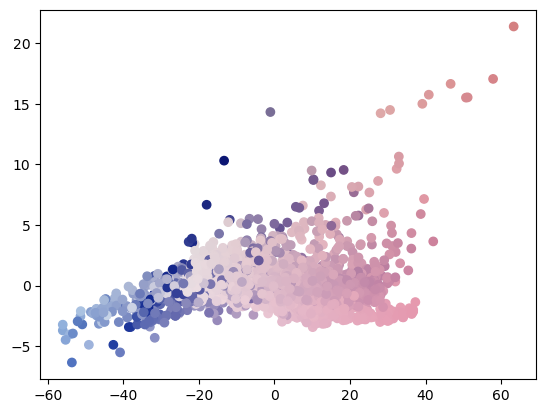

In [246]:
plt.scatter(X[:,1], X[:,2], c=tileMeans/255.0)
plt.show()

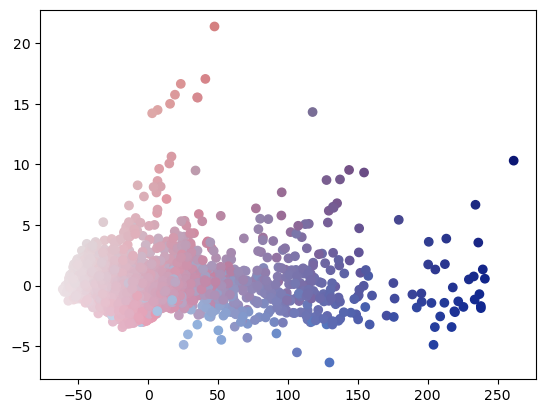

In [247]:
plt.scatter(X[:,0], X[:,2], c=tileMeans/255.0)
plt.show()

In [248]:
X[9,:]

array([114.05357  , -24.820578 ,  -0.8002716], dtype=float32)

In [249]:
X[10,:]

array([29.720257 , 16.002447 ,  1.0537587], dtype=float32)

In [253]:
X[12,:]

array([ 87.44815  , -31.823872 ,  -2.0272923], dtype=float32)

In [256]:
np.where(X[:,0]>150)

(array([  17,   33,  122,  146,  149,  224,  331,  352,  482,  595,  612,
         662,  702,  729,  744,  825,  843,  848,  859,  955, 1083, 1195,
        1197, 1296, 1404, 1560, 1617, 1669, 1687, 1698, 1727, 1890, 1938,
        2029, 2140, 2214, 2272, 2280, 2393, 2696, 2982, 3012, 3019, 3145,
        3165, 3167, 3222, 3293, 3367]),)

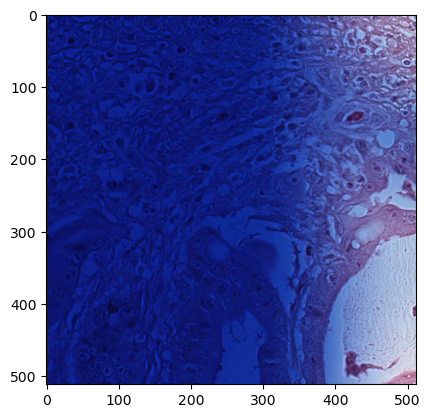

In [259]:
plt.imshow(tfRDataset[2280])

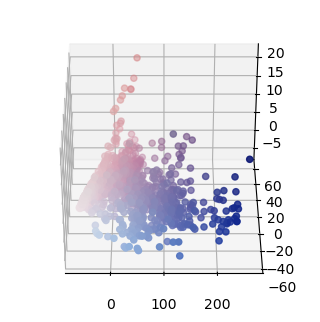

In [271]:
fig = plt.figure(1, figsize=(4, 3))
ax = fig.add_subplot(111, projection="3d", elev=35, azim=270)
ax.set_position([0, 0, 0.85, 1])
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=tileMeans/255.0)
plt.show()

In [274]:
pca.explained_variance_ratio_

array([0.88733006, 0.11127044, 0.00139963], dtype=float32)

Current idea: Slides that have markings will have much of their variance explained by a single PC. Need to apply this idea over a large batch of slides/tiles and see if that is true

Below are scratch ideas that ended up not making as much sense, for example the histograms

In [135]:
def returnArrayHistograms(x, bins = [65,80,110,130,150,170,190,210,220,240,255]):
    return np.transpose(np.stack([np.histogram(x[:,0],bins=bins)[0],np.histogram(x[:,1],bins=bins)[0],np.histogram(x[:,2],bins=bins)[0]]))

In [137]:
tileHistograms = [returnArrayHistograms(x) for x in tfRDataset]

In [202]:
tileHistograms[2]

array([[ 38,  33,  33],
       [108,  97,  94],
       [110, 104, 137],
       [163, 171, 185],
       [211, 216, 226],
       [240, 249, 233],
       [217, 205, 199],
       [ 81,  87,  88],
       [196, 199, 192],
       [142, 146, 126]])

In [197]:
tileHistograms[9]

array([[ 67,  64,  65],
       [353, 370, 330],
       [390, 381, 392],
       [192, 175, 204],
       [167, 175, 170],
       [122, 121, 128],
       [ 82,  89,  78],
       [ 53,  48,  61],
       [ 16,  16,  20],
       [  3,   2,   1]])

In [198]:
tileHistograms[10]

array([[ 26,  28,  22],
       [151, 133, 122],
       [155, 170, 156],
       [242, 225, 212],
       [201, 212, 233],
       [201, 185, 198],
       [135, 157, 177],
       [ 62,  65,  54],
       [216, 205, 210],
       [131, 145, 147]])

In [201]:
tileHistograms[12]

array([[ 37,  28,  27],
       [145, 185, 174],
       [211, 176, 198],
       [150, 173, 144],
       [324, 321, 328],
       [301, 292, 303],
       [ 72,  65,  61],
       [150, 152, 143],
       [132, 130, 146],
       [  2,   4,   2]])

In [145]:
tileHistogramsFlatStacked = np.stack([x.reshape(-1) for x in tileHistograms])
tileHistogramsFlatStacked

array([[  3,   3,   2, ..., 541, 530, 536],
       [  0,   0,   0, ..., 144, 171, 127],
       [ 38,  33,  33, ..., 142, 146, 126],
       ...,
       [  0,   0,   0, ..., 313, 313, 311],
       [  2,   2,   5, ...,  17,  25,  19],
       [ 17,  14,  20, ..., 213, 223, 219]])

In [148]:
pca =  sk.decomposition.PCA()
X = pca.fit_transform(tileHistogramsFlatStacked)
X

array([[ 6.24523645e+02,  3.39216376e+02,  2.18551056e+02, ...,
         3.68018665e-02,  4.19896129e-01, -2.64057023e-02],
       [-2.72597471e+01,  1.03828154e+02, -4.17901659e+02, ...,
         3.10864109e-01,  1.72537155e-02, -1.09588786e-01],
       [-4.02928581e+02,  1.97417402e+01,  4.68074297e+01, ...,
         2.37373013e+00, -1.80467608e+00,  5.10587446e-01],
       ...,
       [ 1.47841999e+03, -5.57221571e+02,  1.65886351e+02, ...,
         4.94688228e-02, -5.01907680e-02, -1.48789811e-03],
       [-2.76554286e+02, -1.85849325e+02, -3.69908376e+02, ...,
         1.03947763e+00, -1.17006961e-02, -3.28356657e-01],
       [ 7.77008430e+02, -3.04184451e+02, -1.95439597e+01, ...,
         4.29559591e+00, -1.16703311e-02,  2.08647191e+00]])

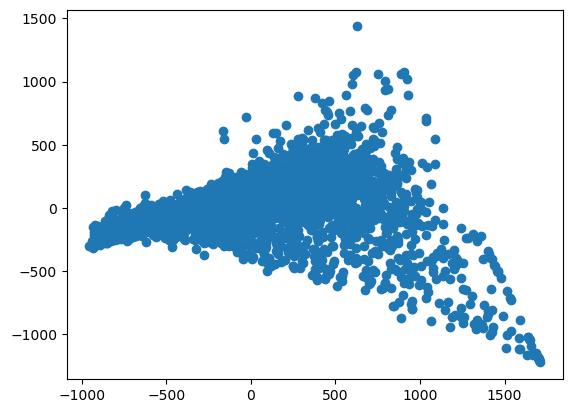

In [153]:
plt.scatter(X[:,0], X[:,1])
plt.show()

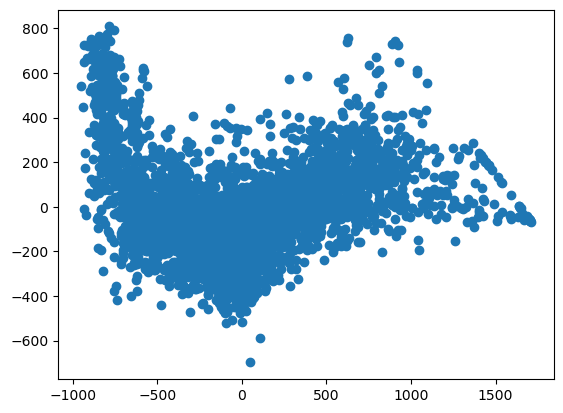

In [154]:
plt.scatter(X[:,0], X[:,2])
plt.show()

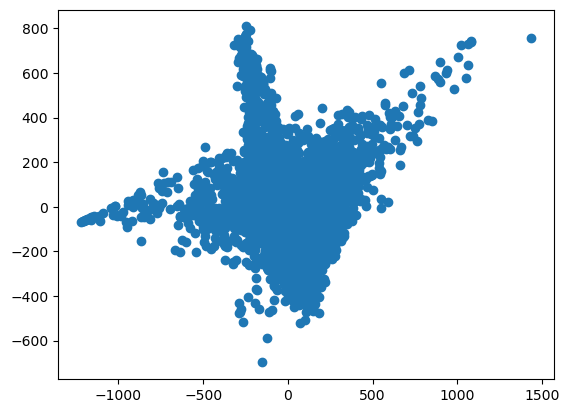

In [155]:
plt.scatter(X[:,1], X[:,2])
plt.show()

In [192]:
X[2,:]

array([-402.92858088,   19.74174019,   46.80742972,  -22.00923507,
        -28.45615393,  -12.80079536,  -18.77136295,   -4.84373715,
         -1.87595677,   16.54106214,   13.23920371,    7.84600689,
          6.1527966 ,   19.26797533,  -10.95622167,   -7.46408267,
         -4.30787323,    3.26595792,    7.50049698,    2.07934232,
         -1.91717282,    2.67092477,    5.86641576,   20.10274617,
         17.6935082 ,   -9.80900957,   -4.89925032,    2.37373013,
         -1.80467608,    0.51058745])

In [193]:
X[10,:]

array([-4.00873952e+02, -5.46142570e+01,  1.98643832e+02, -6.41437028e+01,
        1.18026363e+01, -5.80913825e+01, -4.18629646e+01,  5.31815208e+00,
        4.56612004e+00,  7.41882887e-01, -3.30171975e+00,  5.08188054e+00,
        9.42197969e+00, -2.43772569e+01, -4.89626737e+00,  7.68523082e+00,
        3.96334753e+01, -5.50096268e+00, -4.33475976e+00,  3.78222454e+00,
       -4.73371810e+00,  4.04285498e+00,  1.00591468e+01,  8.41441280e+00,
       -1.07727628e+01,  5.58983225e-01, -1.10985375e+00, -1.83889354e+00,
       -1.82840767e+00,  2.40365046e-01])

In [194]:
X[9,:]

array([-8.25573935e+02, -2.24432362e+02,  6.01798271e+02,  2.26722324e+02,
        4.87859819e+01, -8.13282912e+01,  1.16458276e+02, -9.67628250e+01,
       -1.24964908e+02,  5.00704077e+00,  4.87640278e+00,  2.50708125e+00,
       -1.80317051e-01,  2.07705403e+00,  3.81331573e+00,  6.53897144e+00,
       -1.72732214e+00,  4.34275110e+00,  1.92564487e-01,  8.01282329e-01,
        5.38095909e+00,  1.70024213e+01,  6.10825523e+00,  1.31279671e+01,
        1.87202918e+01,  2.12098843e+01,  1.76901257e-01, -2.23369361e+00,
       -7.48066515e-01,  1.11877765e+00])

The blue overlaps pretty strongly with the Hematoxylin stain, and I expect the red will overlap with the Eosin stain. I think I should try: 
1. PCA on the raw images (maybe principle component analysis)

In [174]:
tsne = sk.manifold.TSNE(perplexity=20)

In [175]:
Xtsne = tsne.fit_transform(tileHistogramsFlatStacked)

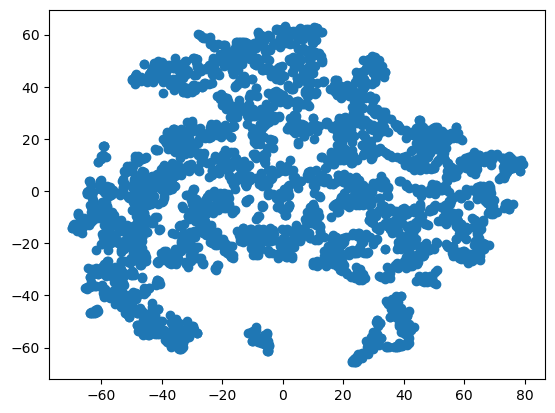

In [176]:
plt.scatter(Xtsne[:,0], Xtsne[:,1])
plt.show()

In [199]:
np.where(np.logical_and(np.logical_and(Xtsne[:,1]< -20,Xtsne[:,0]< -10),Xtsne[:,0]< -10))

(array([   9,   10,   11,   12,   17,   34,   38,   42,   43,   64,   69,
          79,   82,   84,  109,  115,  141,  149,  153,  180,  185,  186,
         187,  189,  191,  192,  196,  197,  203,  204,  207,  214,  224,
         229,  234,  237,  240,  242,  248,  268,  296,  301,  320,  331,
         341,  350,  354,  358,  361,  380,  382,  384,  389,  400,  405,
         410,  411,  412,  415,  422,  426,  428,  433,  441,  442,  445,
         446,  467,  474,  475,  492,  497,  503,  505,  511,  526,  542,
         556,  565,  584,  600,  605,  610,  618,  620,  629,  631,  638,
         644,  651,  661,  665,  682,  704,  705,  706,  718,  727,  735,
         747,  767,  769,  784,  790,  796,  800,  806,  809,  822,  825,
         867,  868,  875,  882,  886,  915,  920,  921,  934,  935,  936,
         944,  955,  971,  978,  979,  984,  985,  988,  998, 1006, 1024,
        1027, 1029, 1055, 1059, 1066, 1072, 1079, 1082, 1094, 1100, 1104,
        1108, 1114, 1134, 1157, 1159, 

In [186]:
Xtsne[2,:]

array([-31.649582, -17.733353], dtype=float32)